In [1]:
import numpy as np
import pandas as pd

import pyphi.data_models as dm  # Prototype code
from pyphi.convert import sbs2sbn, sbn2sbs      

import pyphi
import numpy as np
from pprint import pprint

pyphi.config.PARTITION_TYPE = 'ALL'
pyphi.config.PICK_SMALLEST_PURVIEW = True
pyphi.config.VALIDATE_SUBSYSTEM_STATES = False

# Suppose that a prisoner dies either if A loads B’s gun and B shoots, or if C loads and shoots his gun.
# D = (A and B) or C
# Most intersting state: 101 -> 1. Here they don't want to say that A was a cause of D.

# Constants
# ============================================================================
#! NODES = 4
#! States = 2**NODES

#INI_STATE = (1, 0, 1, 1)
#cm0 = np.array([
#    [0, 0, 0, 1],
#    [0, 0, 0, 1],
#    [0, 0, 0, 1],
#    [0, 0, 0, 0]
#])

label0=A


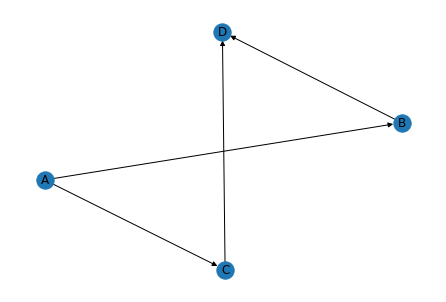

In [2]:
INI_STATE ='1011'
edges = [(0,1),(0,2),(1,3),(2,3)]
net = dm.Net(edges=edges)
label0 = sorted(net.graph.nodes())[0]
print(f'label0={label0}')
net.draw()

In [3]:
net.states.state_str2tuple(INI_STATE)

(1, 0, 1, 1)

#### Convert state_str form to/from state_tuple form
Only done here to facilitate comparison with original.  From scratch code should stick with state_str form.

In [4]:
# Functions
# ============================================================================
def node_logic(in_state):  # MODIFIED for v2 -sp-
    out_state = (in_state[0] and in_state[1]) or in_state[2]
    return tuple([out_state])

ps = net.states.state_str2tuple(INI_STATE)  #  Past State
cs = net.states.state_tuple2str(node_logic(ps)) # Current State
print(f'ps={ps} cs={cs}')

ps=(1, 0, 1, 1) cs=1


## Logical TPM  @@@ !!!
Original code used node_logic to fill a TPM.  This would get big quick. We can get the effect using a Logical TP(M).  The mapping from the states of 3 input nodes (A,B,C) to the state of one output node (D) is done by a func of 3 args). 

In [5]:
tpm = dm.TransProb(in_nodes=list('ABC'), out_nodes=list('D'))
print(f'in_states={tpm.in_states}')
print(f'node_logic((1,0,1))={node_logic((1,0,1))}')
tpm.df

in_states=['000', '001', '010', '011', '100', '101', '110', '111']
node_logic((1,0,1))=(1,)


,0,1
000,0.0,0.0
001,0.0,0.0
010,0.0,0.0
011,0.0,0.0
100,0.0,0.0
101,0.0,0.0
110,0.0,0.0
111,0.0,0.0


In [6]:
net2 = net.to_legacy()
net2

AttributeError: 'Net' object has no attribute 'to_legacy'

In [ ]:
#ps = tuple([int(e > 0.5) for e in state_evo[0]])
#cs = tuple([int(e > 0.5) for e in state_evo[1]])

transition = pyphi.Transition(net.to_legacy(), ps, cs, (0,1,2), (3,))       

In [ ]:
account = pyphi.actual.account(transition)
print(account)

#import pdb; pdb.set_trace() 
print('---------------------------')

all_accounts = pyphi.actual.nexus(net, ps, cs)
all_accounts = sorted(all_accounts, key=lambda nexus: nexus.alpha, reverse=True)

pprint([(a.transition, a.alpha) for a in all_accounts])
# print(nexi[0])
# ac.context_print_mice(nexi[0].context)

In [ ]:
   for psi in range(States):
        ps = tuple(map(int, bin(psi)[2:].zfill(NODES)[::-1]))      
        tpm[psi, :] = node_logic(ps)

    state_evo = state_evolution(INI_STATE, 1)
    print(state_evo)
    print('---------------------------')
    
    print(f'tpm.shape={tpm.shape}')
    pd.DataFrame(tpm)
  

In [ ]:
cm = dm.CM()
cm.from_legacy(cm=cm0, labels=list('ABCD'))
cm.df

In [ ]:
    net = pyphi.Network(tpm, cm)

    ps = tuple([int(e > 0.5) for e in state_evo[0]])
    cs = tuple([int(e > 0.5) for e in state_evo[1]])

    transition = pyphi.Transition(net, ps, cs, (0,1,2), (3,))       
    
    account = pyphi.actual.account(transition)
    print(account)

    #import pdb; pdb.set_trace() 
    print('---------------------------')

    all_accounts = pyphi.actual.nexus(net, ps, cs)
    all_accounts = sorted(all_accounts, key=lambda nexus: nexus.alpha, reverse=True)

    pprint([(a.transition, a.alpha) for a in all_accounts])
    # print(nexi[0])
    # ac.context_print_mice(nexi[0].context)

    #! import pdb; pdb.set_trace() 

In [ ]:
len(cm0)

In [ ]:
cwd

In [ ]:
%cwd

In [ ]:
pwd